### Note:  
All the code explanations are similar to those in the `exp_result_analysis_euclidean_l2.ipynb`, with the primary difference being the metric used here is cosine. Please refer to `exp_result_analysis_euclidean_l2.ipynb` before going through this code.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Read the initial CSV file and apply remove_matched_items
df = pd.read_csv('exp_matches_cosine.csv')

# Function to remove matched items
def remove_matched_items(row):
    missing_filename = row['missing_filename']
    matched_filenames = row['unknowns_matched_filenames'].split(', ')
    l2_values = row['VGG-Face_cosine'].split(', ')

    if missing_filename in matched_filenames:
        index = matched_filenames.index(missing_filename)
        del matched_filenames[index]
        del l2_values[index]

    row['unknowns_matched_filenames'] = ', '.join(matched_filenames)
    row['VGG-Face_cosine'] = ', '.join(l2_values)
    return row
df = df.apply(remove_matched_items, axis=1)
# Function to extract Case ID
def extract_case_id(filename):
    return filename.split('/')[1].split('_')[0]

# Function to count matches
def count_matches(case_id, filenames):
    filenames_list = filenames.split(', ')
    return sum(case_id in filename for filename in filenames_list)

# Function to remove duplicates and keep corresponding values aligned
def remove_duplicates_and_align_values(filenames, values):
    unique_filenames = []
    unique_values = []
    seen = set()

    for filename, value in zip(filenames.split(', '), values.split(', ')):
        if filename not in seen:
            seen.add(filename)
            unique_filenames.append(filename)
            unique_values.append(value)

    return ', '.join(unique_filenames), ', '.join(unique_values)



# Extract Case ID for each row
df['Case ID'] = df['missing_filename'].apply(extract_case_id)

# Count the occurrences of each Case ID and filter out rows with unique Case IDs
case_counts = df['Case ID'].value_counts()
case_ids_to_remove = case_counts[case_counts == 1].index
df = df[~df['Case ID'].isin(case_ids_to_remove)]

# Aggregating data
aggregated_data = df.groupby('Case ID').agg({
    'unknowns_matched_filenames': lambda x: ', '.join(x),
    'VGG-Face_cosine': lambda x: ', '.join(map(str, x))
}).reset_index()

# Remove duplicates and align values
aggregated_data[['unknowns_matched_filenames', 'VGG-Face_cosine']] = aggregated_data.apply(
    lambda row: remove_duplicates_and_align_values(row['unknowns_matched_filenames'], row['VGG-Face_cosine']), 
    axis=1, result_type='expand'
)

# Adding matches_counts
aggregated_data['matches_counts'] = aggregated_data.apply(
    lambda row: count_matches(row['Case ID'], row['unknowns_matched_filenames']), axis=1
)

# Save the aggregated data to a new CSV file
aggregated_data.to_csv('aggregated_data_cosine.csv', index=False)



In [7]:

# Load the CSV file
df = pd.read_csv('aggregated_data_cosine.csv')

# Identifying rows where matched_counts is 0
rows_with_zero_matches = (df['matches_counts'] == 0).sum()
# Identifying rows where matched_counts is at least 1
rows_with_at_least_one_match = (df['matches_counts'] >= 1).sum()

print('Total Case IDs with atleast 2 images: ', len(df))
print("Number of Case IDs with no matches in the Pool: ",rows_with_zero_matches)
print("Number of Case IDs with at least one match in the Pool: ",rows_with_at_least_one_match)



Total Case IDs with atleast 2 images:  249
Number of Case IDs with no matches in the Pool:  18
Number of Case IDs with at least one match in the Pool:  231


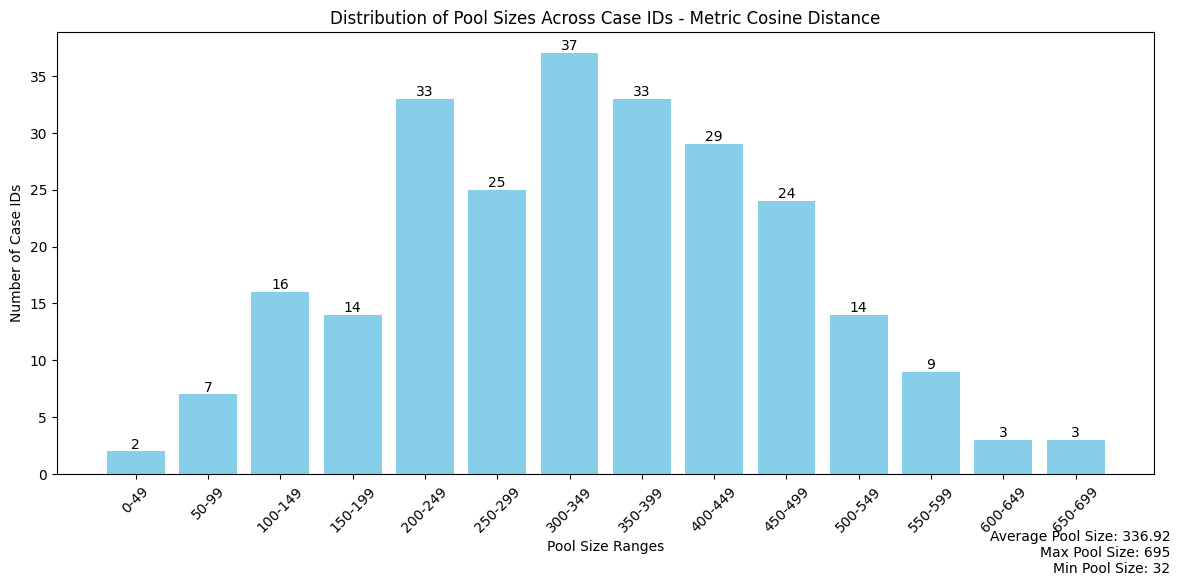

In [2]:
# Load the aggregated data from the CSV file
aggregated_data_cosine = pd.read_csv('aggregated_data_cosine.csv')

# Function to count unique filenames for a set of filenames
def count_distinct_filenames(filenames):
    unique_filenames = set(filenames.split(', '))
    return len(unique_filenames)


# Calculate the distinct count of filenames for each Case ID
aggregated_data_cosine['distinct_filenames_count'] = aggregated_data_cosine['unknowns_matched_filenames'].apply(count_distinct_filenames)

# Determine the maximum, minimum, and average count of distinct filenames
max_filename_count = aggregated_data_cosine['distinct_filenames_count'].max()
min_filename_count = aggregated_data_cosine['distinct_filenames_count'].min()
average_filename_count = aggregated_data_cosine['distinct_filenames_count'].mean()

# Create boundaries for pool size categories
pool_size_boundaries = [i for i in range(0, max_filename_count + 50, 50)]

# Function to assign pool size category based on count
def assign_pool_category(file_count):
    for i in range(len(pool_size_boundaries) - 1):
        if pool_size_boundaries[i] <= file_count < pool_size_boundaries[i+1]:
            return f"{pool_size_boundaries[i]}-{pool_size_boundaries[i+1] - 1}"
    return f"{pool_size_boundaries[-2]}+"

# Assign pool size category for each Case ID based on its distinct filename count
aggregated_data_cosine['pool_size_category'] = aggregated_data_cosine['distinct_filenames_count'].apply(assign_pool_category)

# Count the frequency of each pool size category
pool_category_frequencies = aggregated_data_cosine['pool_size_category'].value_counts()

# Sort pool size categories for plotting
sorted_pool_categories = sorted(pool_category_frequencies.index, key=lambda item: int(item.split('-')[0]))
sorted_frequency_counts = [pool_category_frequencies[category] for category in sorted_pool_categories]

# Plot the sorted pool size frequencies
plt.figure(figsize=(12, 6))
plt.bar(sorted_pool_categories, sorted_frequency_counts, color='skyblue')
plt.xlabel('Pool Size Ranges')
plt.ylabel('Number of Case IDs')
plt.title('Distribution of Pool Sizes Across Case IDs - Metric Cosine Distance')
plt.xticks(rotation=45)

# Positioning the average, max, and min information to avoid overlap
plt.figtext(0.99, 0.01, f'Average Pool Size: {average_filename_count:.2f}\n'
                         f'Max Pool Size: {max_filename_count}\nMin Pool Size: {min_filename_count}', 
            horizontalalignment='right', verticalalignment='bottom')

# Annotate each bar with its corresponding count
for i, count in enumerate(sorted_frequency_counts):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.tight_layout(pad=2)  # Adjust the layout to prevent clipping of tick-labels
plt.show()


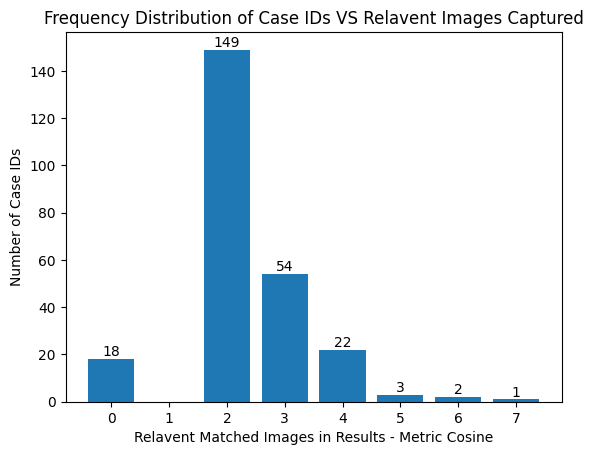

In [5]:

# Load the aggregated data CSV file
aggregated_data = pd.read_csv('aggregated_data_cosine.csv')

# Extract match counts
match_counts = aggregated_data['matches_counts']

# Find the unique match counts and their frequencies
match_count_frequencies = match_counts.value_counts()

# Sort the data for better visualization
match_count_frequencies.sort_index(inplace=True)

# Plotting
plt.bar(match_count_frequencies.index, match_count_frequencies.values)
plt.xlabel('Relavent Matched Images in Results - Metric Cosine')
plt.ylabel('Number of Case IDs')
plt.title('Frequency Distribution of Case IDs VS Relavent Images Captured')

# Adding values on the bars
for index, value in match_count_frequencies.items():
    plt.text(index, value, str(value), ha='center', va='bottom')

plt.show()


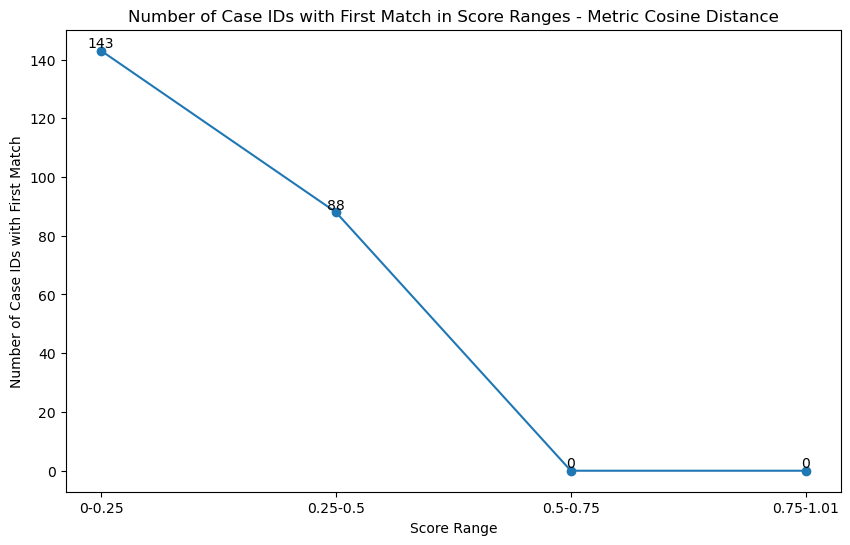

In [9]:
file_path = 'aggregated_data_cosine.csv' 
def count_first_matches_in_score_ranges(file_path, score_ranges):
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Initialize counts for each score range
    count_matches = [0] * len(score_ranges)

    # Process each row in the DataFrame
    for index, row in data.iterrows():
        case_id = row['Case ID']
        filenames = row['unknowns_matched_filenames'].split(', ')
        scores = list(map(float, row['VGG-Face_cosine'].split(', ')))

        # Create a list of tuples (filename, score)
        filename_score_pairs = list(zip(filenames, scores))

        # Sort the list by score
        filename_score_pairs.sort(key=lambda x: x[1])

        # Check if Case ID is in the first match within score ranges
        captured_match = False
        for filename, score in filename_score_pairs:
            for i, score_range in enumerate(score_ranges):
                if case_id in filename and score_range[0] <= score < score_range[1]:
                    count_matches[i] += 1
                    captured_match = True
            
            if captured_match:
                break
            

    return count_matches


# Define score ranges
score_ranges = [(0, 0.25), (0.25, 0.50), (0.50, 0.75), (0.75, 1.01)]
match_counts = count_first_matches_in_score_ranges(file_path, score_ranges)

# Range labels for plotting
range_labels = [f"{r[0]}-{r[1]}" for r in score_ranges]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range_labels, match_counts, marker='o')

# Add text label for each point
for i, txt in enumerate(match_counts):
    plt.text(range_labels[i], match_counts[i], txt, ha='center', va='bottom')

plt.title('Number of Case IDs with First Match in Score Ranges - Metric Cosine Distance')
plt.xlabel('Score Range')
plt.ylabel('Number of Case IDs with First Match')
plt.xticks(range_labels)

plt.show()



Number of Case IDs with first match in the top 10 pool: 162
Number of Case IDs with first match in the top 20 pool: 176
Number of Case IDs with first match in the top 30 pool: 182
Number of Case IDs with first match in the top 40 pool: 191
Number of Case IDs with first match in the top 50 pool: 200
Number of Case IDs with first match in the top 60 pool: 204
Number of Case IDs with first match in the top 70 pool: 207
Number of Case IDs with first match in the top 80 pool: 210
Number of Case IDs with first match in the top 90 pool: 210
Number of Case IDs with first match in the top 100 pool: 210
Number of Case IDs with first match in the top 425 pool: 231


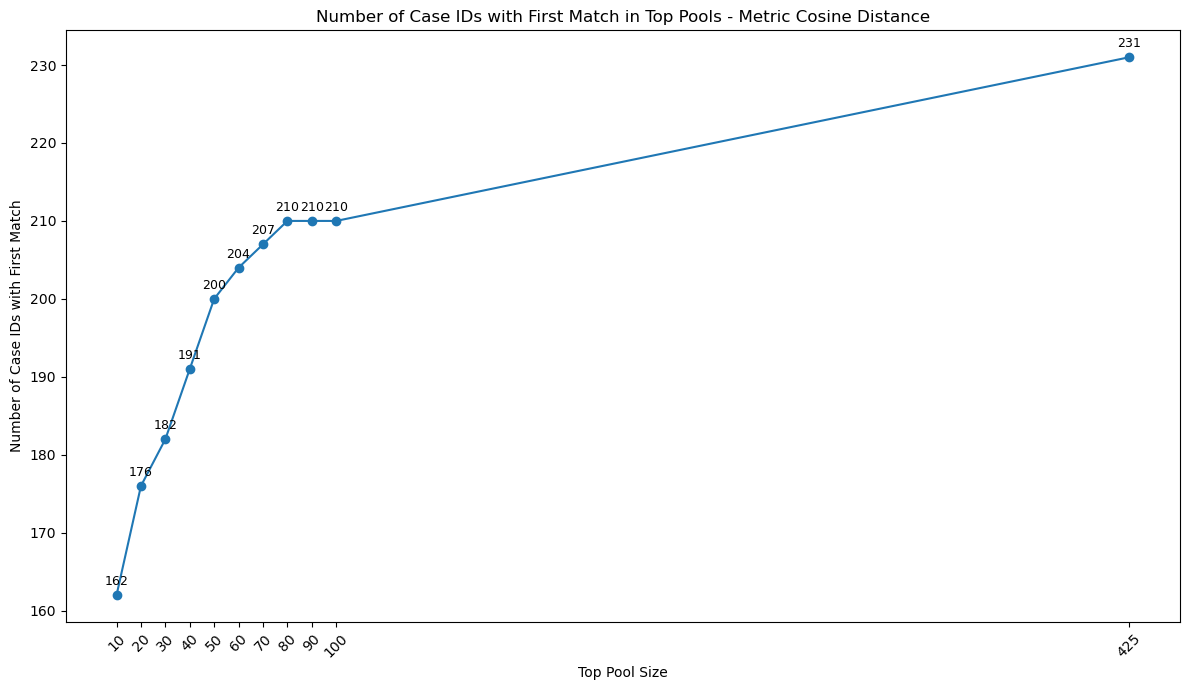

In [8]:

file_path = 'aggregated_data_cosine.csv' 

def count_first_matches_in_top_pool(file_path, top_pool_size):
    # Load the CSV data
    data = pd.read_csv(file_path)

    # Count of Case IDs with first match in top pool
    count_matches = 0

    # Process each row in the DataFrame
    for index, row in data.iterrows():
        case_id = row['Case ID']
        filenames = row['unknowns_matched_filenames'].split(', ')
        scores = list(map(float, row['VGG-Face_cosine'].split(', ')))

        # Create a list of tuples (filename, score)
        filename_score_pairs = list(zip(filenames, scores))

        # Sort the list by score in descending order
        filename_score_pairs.sort(key=lambda x: x[1])

        # Check if Case ID is in any of the top pool filenames
        for filename, _ in filename_score_pairs[:top_pool_size]:
            if case_id in filename:
                count_matches += 1
                break

    return count_matches



# Define the pool sizes
pool_sizes = list(range(10, 101, 10)) + [425]  # Top 10, 20, ..., 100

match_counts = []

# Iterate over each pool size and calculate counts
for pool_size in pool_sizes:
    count = count_first_matches_in_top_pool(file_path, pool_size)
    match_counts.append(count)
    print(f"Number of Case IDs with first match in the top {pool_size} pool: {count}")

# Plotting the results
plt.figure(figsize=(12, 7))
plt.plot(pool_sizes, match_counts, marker='o')
for i, txt in enumerate(match_counts):
    plt.annotate(txt, (pool_sizes[i], match_counts[i]), textcoords="offset points", xytext=(0,5), ha='center', va='bottom', fontsize=9)
plt.title('Number of Case IDs with First Match in Top Pools - Metric Cosine Distance')
plt.xlabel('Top Pool Size')
plt.ylabel('Number of Case IDs with First Match')
plt.xticks(pool_sizes, rotation=45)
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlapping
plt.show()
